# Creation of Phase Height Change Rasters
## Using naive averaging / coherence / incidence angle

In [2]:
import xarray as xr
import os 
import sys
sys.path.append('/home/s1332488/code/tandex')
from deramp import remove_plane
import glob
from matplotlib import pyplot as plt
import numpy as np
import rioxarray as rx
import geopandas as gpd
from datetime import datetime as dt
import pandas as pd
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import stats

# Get TDX derived DEMs ------------------------------------
DEM_dir = '/disk/scratch/local.4/harry/DEM/NC/merged/full/corrected/'
SUBSET_DIR = '/disk/scratch/local.4/harry/DEM/NC/merged/subset/'
files = glob.glob(DEM_dir+'*.nc')
subset_files = glob.glob(SUBSET_DIR+'*.nc')
f_per = [f for f in files if 'PER' in f]
f_gab = [f for f in files if 'GAB' in f]
f_gabA = [f for f in f_gab if '_A_' in f]
f_gabD = [f for f in f_gab if '_D_' in f]
f_gab_sub = [f for f in subset_files if 'GAB' in f]
f_gabA_sub = [f for f in f_gab_sub if '_A_' in f]
f_gabD_sub = [f for f in f_gab_sub if '_D_' in f]

# Get forest inventory data --------------------------------------------------------
INVENTORY_dir='/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/Forest_inventory/'
g_df = pd.read_csv(INVENTORY_dir+'GabonPlots.csv',index_col='Plot')
p_df = pd.read_csv(INVENTORY_dir+'PeruPlots.csv',index_col='Plot')

# Get plot shapefiles -------------------------------------------
SHP_dir='/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/core_plot_shapefiles/'
shps = gpd.read_file(SHP_dir+'core_plots_10mBuffer.shp')
#shps_nobuff = gpd.read_file(SHP_dir+'core_plots.shp')
shps_bg = gpd.read_file(SHP_dir+'background_plots.shp')

TDX_extent = gpd.read_file('/exports/csce/datastore/geos/users/s1332488/chapter1_data/tdx_overlap.shp')

datastore = '/exports/csce/datastore/geos/users/s1332488/chapter1_data/'

In [2]:
# Convenience routines ----------

def open_ds(dataset,looks):
    # Open net_cdf file ready to be cropped using rio
    filename = [x for x in dataset if '_ML'+str(looks)+'_' in x][0]
    try:
        ds = xr.open_dataset(filename).drop(['metadata','crs']).rio.write_crs('EPSG:4326')
    except:
        ds = xr.open_dataset(filename).rio.write_crs('EPSG:4326')
    return ds

def crop(ds,plot,all_touched=False):
    # Crop an xarray object 'ds' to plot
    # plot is a string e.g. 'PC1' or 'GC4'
    # pass all_touched = True to include pixels that partially intersect the plot
    ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    if 'B' in plot:
        shape = shps_bg[shps_bg.layer==plot].geometry
    else:
        shape = shps[shps.layer==plot].geometry
    return ds.rio.clip(shape,all_touched=all_touched)

In [3]:
def get_naive_changeMap():
    change = 0.5*(changeA+changeD).where(~neither)
    return change - change.mean()

def get_asc_changeMap():
    changeAA = ascending.height.isel(t=[2,3]).mean(dim='t') - ascending.height.isel(t=[0,1]).mean(dim='t')
    where = cohA > coh_min
    changeAA = changeAA.where(where)
    return changeAA - changeAA.mean()

def get_des_changeMap():
    changeDD = descending.height.isel(t=[2,3]).mean(dim='t') - descending.height.isel(t=[0,1]).mean(dim='t')
    where = cohD > coh_min
    changeDD = changeDD.where(where)
    return changeDD - changeDD.mean()

def get_coh_changeMap():
    whereA = cohA > cohD
    changeAA = changeA - changeA.where(whereA).mean()
    changeDD = changeD - changeD.where(~whereA).mean() # Remove offsets individually
    change = changeAA.where(whereA,other=changeDD)
    masked= change.where(~neither)
    return masked

def get_incidence_changeMap():
    whereA = angleA > angleD
    changeAA = changeA - changeA.where(whereA).mean()
    changeDD = changeD - changeD.where(~whereA).mean() # Remove offsets individually
    change = changeAA.where(whereA,other=changeDD)
    masked= change.where(~neither)
    return masked

def changeMap_coh_and_angle(theta_crit):
    steep = np.fabs(angleA - angleD) > theta_crit
    whereA = (cohA>cohD)*~steep + (angleA > angleD)*steep
    naive = 0.5*(changeA+changeD).where(~neither)
    changeAA = changeA - changeA.where(whereA).mean()
    changeDD = changeD - changeD.where(~(whereA|neither)).mean() # Remove offsets individually
    change = changeAA.where(whereA,other=changeDD)
    masked = change.where(~neither)
    return masked
    

In [5]:
# SUBSET ##################################
coh_min = 0.4
theta_crit = 20 # min difference between A and D local incidence angle to select based on angle

# Open local incidence angle
angleA = xr.open_dataset(datastore+'ASCENDING_3L_PROJ_INC_ANGLE.nc').rio.write_crs('EPSG:4326')
angleD = xr.open_dataset(datastore+'DESCENDING_3L_PROJ_INC_ANGLE.nc').rio.write_crs('EPSG:4326')
# open ML3 datasets and interpolate everything to the same grid
ascending = open_ds(f_gabA_sub,3)
descending = open_ds(f_gabD_sub,3).interp(lat=ascending.lat,lon=ascending.lon,method='nearest')
angleA = angleA.interp(lat=ascending.lat,lon=ascending.lon,method='nearest').projectedLocalIncidenceAngle
angleD = angleD.interp(lat=ascending.lat,lon=ascending.lon,method='nearest').projectedLocalIncidenceAngle
# Clip to area of overlap between pass directions
angleA = angleA.rio.clip(TDX_extent.geometry)
angleD = angleD.rio.clip(TDX_extent.geometry)
ascending = ascending.rio.clip(TDX_extent.geometry)
descending = descending.rio.clip(TDX_extent.geometry)
# Run code
cohA = ascending.coh.median(dim='t')
cohD = descending.coh.median(dim='t')
neither = (cohA < coh_min) & (cohD < coh_min)
changeA = ascending.height.isel(t=[2]).mean(dim='t') - ascending.height.isel(t=[1]).mean(dim='t')
changeD = descending.height.isel(t=[2]).mean(dim='t') - descending.height.isel(t=[1]).mean(dim='t')

#change_coh = get_coh_changeMap()
change_naive = get_naive_changeMap()
# change_inc = get_incidence_changeMap()
change_smart = changeMap_coh_and_angle(theta_crit)
change_asc = get_asc_changeMap()
change_des = get_des_changeMap()
# Combine into dataset and get stats
subset_ds = xr.Dataset(
    data_vars={#'change_coh':change_coh,
               'change_naive':change_naive,
               'change_asc' :change_asc,
               'change_des' : change_des,
#                'change_inc':change_inc,
               'change_smart':change_smart,
               'angleA':angleA})#,
               #'angleD':angleD})
subset_ds.to_netcdf('/exports/csce/datastore/geos/users/s1332488/chapter1_data/change_subset.nc')
#subset_ds.rio.to_raster(datastore+'change_3L_proj_angles_subset.tif')
slope_bins = subset_ds.groupby_bins('angleA',bins=np.linspace(0,60,24))
mean = slope_bins.mean()
std = slope_bins.std()
subset_ds

<xarray.Dataset>
Dimensions:       (lat: 655, lon: 1213)
Coordinates:
  * lat           (lat) float64 -0.1279 -0.1279 -0.128 ... -0.1604 -0.1605
  * lon           (lon) float64 12.24 12.24 12.24 12.24 ... 12.3 12.3 12.3 12.3
    spatial_ref   int64 0
Data variables:
    change_naive  (lat, lon) float64 nan nan nan nan ... -0.3387 -1.196 -1.252
    change_asc    (lat, lon) float64 2.159 7.048 3.272 ... -1.856 -0.8313 -1.304
    change_des    (lat, lon) float64 nan nan nan nan ... 3.419 6.329 3.254
    change_smart  (lat, lon) float64 nan nan nan nan ... 0.7137 -0.7166 0.49
    angleA        (lat, lon) float32 34.23 34.3 34.36 ... 36.86 36.98 37.11

In [221]:
## FULL AREA ##

# Open local incidence angle
angleA = xr.open_dataset(datastore+'ASCENDING_3L_PROJ_INC_ANGLE.nc').rio.write_crs('EPSG:4326')
angleD = xr.open_dataset(datastore+'DESCENDING_3L_PROJ_INC_ANGLE.nc').rio.write_crs('EPSG:4326')
# open ML3 datasets and interpolate everything to the same grid
ascending = open_ds(f_gabA,3)
descending = open_ds(f_gabD,3).interp(lat=ascending.lat,lon=ascending.lon,method='nearest')
angleA = angleA.interp(lat=ascending.lat,lon=ascending.lon,method='nearest').projectedLocalIncidenceAngle
angleD = angleD.interp(lat=ascending.lat,lon=ascending.lon,method='nearest').projectedLocalIncidenceAngle
# Clip to area of overlap between pass directions
angleA = angleA.rio.clip(TDX_extent.geometry)
angleD = angleD.rio.clip(TDX_extent.geometry)
ascending = ascending.rio.clip(TDX_extent.geometry)
descending = descending.rio.clip(TDX_extent.geometry)
# Run code
cohA = ascending.coh.median(dim='t')
cohD = descending.coh.median(dim='t')
neither = (cohA < coh_min) & (cohD < coh_min)
changeA = ascending.height.isel(t=[2]).mean(dim='t') - ascending.height.isel(t=[1]).mean(dim='t')
changeD = descending.height.isel(t=[2]).mean(dim='t') - descending.height.isel(t=[1]).mean(dim='t')

#change_coh = get_coh_changeMap()
change_naive = get_naive_changeMap()
#change_inc = get_incidence_changeMap()
change_smart = changeMap_coh_and_angle(theta_crit)
# Combine into dataset and get stats
change_ds = xr.Dataset(
    data_vars={#'change_coh':change_coh,
               'change_naive':change_naive,
               #'change_inc':change_inc,
               'change_smart':change_smart,
               'angleA':angleA})
               #'angleD':angleD})
change_ds['change_smart'] = (change_ds.dims, remove_plane(change_ds.change_smart.values,10000) )
change_ds['change_naive'] = (change_ds.dims, remove_plane(change_ds.change_naive.values,10000) )
change_ds.to_netcdf('/exports/csce/datastore/geos/users/s1332488/chapter1_data/change.nc')
change_ds.rio.to_raster(datastore+'change_3L_proj_angles.tif')
slope_bins = change_ds.groupby_bins('angleA',bins=np.linspace(12,54,24))
mean = slope_bins.mean()
std = slope_bins.std()
change_ds

<xarray.Dataset>
Dimensions:       (lat: 8556, lon: 5538)
Coordinates:
  * lat           (lat) float64 0.1327 0.1326 0.1326 ... -0.2936 -0.2936 -0.2937
  * lon           (lon) float64 12.23 12.23 12.23 12.23 ... 12.51 12.51 12.51
    spatial_ref   int64 0
Data variables:
    change_naive  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    change_smart  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    angleA        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

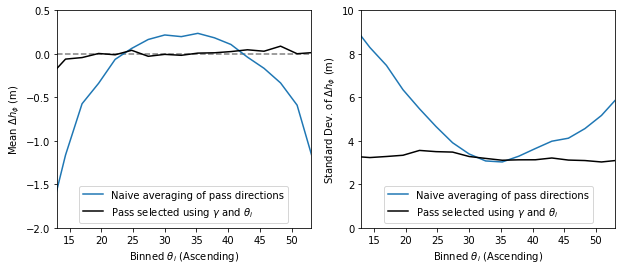

In [76]:
fig,axs=plt.subplots(1,2,figsize=(10,4))

bin_centres = [v.mid for v in mean.angleA_bins.values]
#axs[0].plot(bin_centres,mean.change_coh,label='Coherent')
axs[0].plot(bin_centres,mean.change_naive,label='Naive averaging of pass directions')
#axs[0].plot(bin_centres,mean.change_inc,label='Angle')
axs[0].plot(bin_centres,mean.change_smart,color='black',label='Pass selected using $\gamma$ and $\\theta_i$')
axs[0].axhline(y=0,zorder=1,color='grey',ls='dashed')
axs[0].legend(loc='lower center')
axs[0].set(xlabel='Binned $\\theta_i$ (Ascending)',ylabel='Mean $\Delta h_\phi$ (m)')
axs[0].set(xlim=(13,53),ylim=(-2,0.5))

#axs[1].plot(np.array(bin_centres),std.change_coh,label='Coherent')
axs[1].plot(bin_centres,std.change_naive,label='Naive averaging of pass directions')
#axs[1].plot(np.array(bin_centres),std.change_inc,label='Angle')
axs[1].plot(np.array(bin_centres),std.change_smart,color='black',label='Pass selected using $\gamma$ and $\\theta_i$')
axs[1].set(xlabel='Binned $\\theta_i$ (Ascending)',ylabel='Standard Dev. of $\Delta h_\phi$ (m)')
axs[1].legend(loc='lower center')
axs[1].set(xlim=(13,53),ylim=(0,10))
#plt.savefig('/home/s1332488/chapter1/passdir_change_stability.png',dpi=300)
plt.show()

## Coarsening to 1 ha

In [222]:
# pixel size in metres is 5.537
# to get 1 ha, coarsen by factor of 16*16

coarse =change_ds.coarsen(dim={'lat':16,'lon':16},boundary='trim').mean()
N_nan = change_ds.isnull().coarsen(dim={'lat':16,'lon':16},boundary='trim').sum()
coarse = coarse.where(N_nan < 50)
coarse.rename({'lat':'y','lon':'x'}).rio.to_raster(datastore+'change_3L_proj_angles_1ha.tif')
coarse

<xarray.Dataset>
Dimensions:       (lat: 534, lon: 346)
Coordinates:
  * lat           (lat) float64 0.1323 0.1315 0.1307 ... -0.2911 -0.2919 -0.2927
  * lon           (lon) float64 12.23 12.23 12.23 12.23 ... 12.5 12.5 12.5 12.51
    spatial_ref   int64 0
Data variables:
    change_naive  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    change_smart  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    angleA        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [73]:
def get_dh_dagb(changeMap,plotting):
    q = changeMap.mean()
    DH_list= []
    DAGB_list = []
    error_list = []
    j=0
    for plot in ['GC'+i for i in ['1','2','3','4']]:
        DH = crop(changeMap,plot,all_touched=True).mean() - q
        DAGB = -g_df['AGB_loss'][plot]
        DAGB_err = g_df['dAGB_loss'][plot]

        error_list.append(DAGB_err)
        DH_list.append(DH)
        DAGB_list.append(DAGB)
        if plotting == True:
            plt.plot(DAGB,DH,'o',label=plot,color='black')
            plt.errorbar(DAGB,DH,
                         xerr=DAGB_err,
                         yerr=[0.60,0.32,0.30,0.43][j],
                         color='black')
            #plt.annotate(plot,xy=(DAGB-0.5,DH+0.1))
        j+=1
    return DH_list, DAGB_list, error_list

change_naive
0.519200582491859


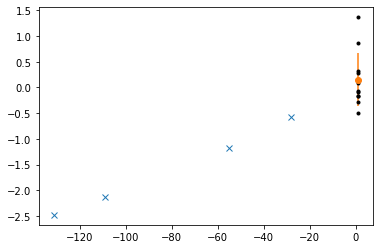

change_smart
0.46094071454713714


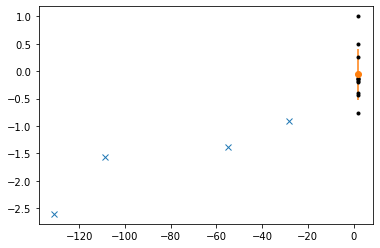

change_asc
0.5965864826627651


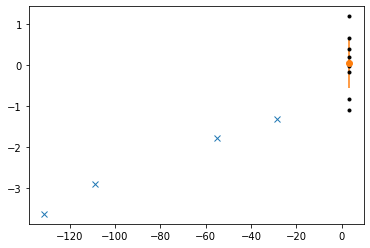

change_des
0.8320262453291002


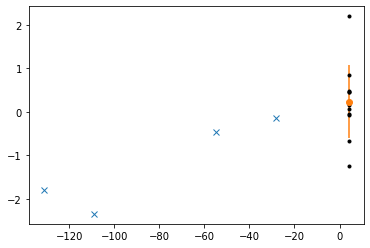

In [10]:
i=1
for layer in ['change_naive','change_smart','change_asc','change_des']:
    da = subset_ds[layer]
    core = ['GC1','GC2','GC3','GC4']
    bg = ['GB'+str(i) for i in range(1,12)]
    dh_core = []
    dAGB = []
    dh_bg = []
    for c in core:
        dh_core.append(crop(da,c).mean())
        dAGB.append(-g_df['AGB_loss'][c])
    for b in bg:
        dh_bg.append(crop(da,b).mean())
    slope, intercept, r, p, se = stats.linregress(dAGB,dh_core)
    #
    dh_bg = np.array(dh_bg)
    sensitivity_h = (dh_bg).mean() - (dh_bg).std()
    sensitivity = (sensitivity_h - intercept)/slope
    mean = dh_bg.mean()
    std = dh_bg.std()
    print(layer)
    print(std)
    plt.plot(dAGB,dh_core,'x')
    #plt.plot(dh_bg,'.',color='black')
    #plt.show()
    plt.errorbar(i,mean,yerr=std,label=layer,marker='o')
    plt.plot(11*[i],dh_bg,'.',color='black')
    plt.show()
    i+=1
# plt.axhline(y=0,color='grey')
# plt.legend()
# plt.show()

## 30 m analysis of coherence vs incidence angle

In [18]:
ds = xr.open_dataset('/exports/csce/datastore/geos/users/s1332488/chapter1_data/slope_aspect_coh.nc')

# manual binning of the data

sbins=np.linspace(0,40,20)  # slope steepness (SRTM)
abins=np.linspace(0,360,36) # Slope aspect (SRTM)

result = np.zeros((sbins.size-1,abins.size-1,3))

for i in range(sbins.size-1):
    for j in range(abins.size-1):
        ss = (ds.slope>=sbins[i])&(ds.slope<sbins[i+1])
        aa = (ds.aspect>=abins[j])&(ds.aspect<abins[j+1])
        result[i,j,0] = ds.cohA.where(aa&ss).mean()
        result[i,j,1] = ds.cohD.where(aa&ss).mean()
        result[i,j,2] = ds.coh_both.where(aa&ss).mean()
        

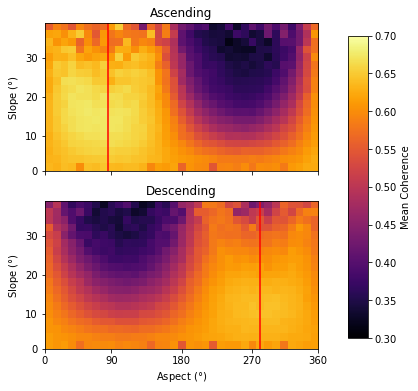

In [32]:
# Plot coh vs slope aspect / steepness

fig,axs=plt.subplots(2,1,figsize=(9,6),sharex=True)

axs[0].imshow(result[:,:,0],origin='lower',cmap='inferno',vmin=0.3,vmax=0.7)
axs[0].set_title('Ascending')
axs[1].set_title('Descending')
im = axs[1].imshow(result[:,:,1],origin='lower',cmap='inferno',vmin=0.3,vmax=0.7)
#axs[2].imshow(result[:,:,2],origin='lower',cmap='inferno',vmin=0.3,vmax=0.7)
#axs[2].set_title('Both Passes')
for ax in axs:
    ax.set(yticks=[-0.5,4,9,14],yticklabels=['0','10','20','30'])
    ax.set_ylabel('Slope ($\degree$)')
axs[1].set(xticks=[-0.5,8,17,26,34.5],xticklabels=['0','90','180','270','360'])
axs[1].set_xlabel('Aspect ($\degree$) ')
cbar_ax = fig.add_axes([0.77, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Mean Coherence', rotation=90)
axs[0].axvline(x=(79.4/360)*34.5,color='red')
axs[1].axvline(x=(282/360)*34.5,color='red')
plt.savefig('/home/s1332488/chapter1/coh_vs_slopeAspect.png',dpi=300)
plt.show()

# Some stats in comparison to Sentinel-1 Alerts

In [4]:
#change = xr.open_dataset('/exports/csce/datastore/geos/users/s1332488/chapter1_data/change.nc')
change = xr.open_dataset('/disk/scratch/local/harry/temp/change.nc')
RADD = xr.open_rasterio(datastore+'RADD/RADD_Jan20_Jun20.tif')
rolled =change.rolling(dim={'lat':16,'lon':16},min_periods=50).mean()
TDX_10m = rolled.change_smart.drop('spatial_ref').rename({'lat':'y','lon':'x'}).interp_like(RADD,method='nearest')
RADD = RADD.sel(band=1).drop('band').rename('RADD')
RADD = xr.merge([RADD,TDX_10m])
RADD = RADD.where(~RADD.change_smart.isnull())


/home/s1332488/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
rad_binned = RADD.groupby_bins('change_smart',bins=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5]).mean()

In [6]:
N =RADD.groupby_bins('change_smart',bins=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5]).count()

In [7]:
rad_binned

<xarray.Dataset>
Dimensions:            (change_smart_bins: 11)
Coordinates:
  * change_smart_bins  (change_smart_bins) object (-3.0, -2.5] ... (2.0, 2.5]
Data variables:
    RADD               (change_smart_bins) float64 0.006079 ... 7.271e-05
    change_smart       (change_smart_bins) float64 -2.717 -2.21 ... 1.693 2.204

In [8]:
N

<xarray.Dataset>
Dimensions:            (change_smart_bins: 11)
Coordinates:
  * change_smart_bins  (change_smart_bins) object (-3.0, -2.5] ... (2.0, 2.5]
Data variables:
    RADD               (change_smart_bins) int64 14146 34508 ... 103151 27506
    change_smart       (change_smart_bins) int64 14146 34508 ... 103151 27506

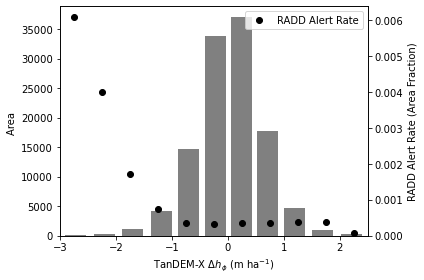

In [51]:
for i in range(11):
    plt.bar(rad_binned.change_smart[i],N.RADD[i].values/100,width=0.75/2,color='grey')
#     plt.text(rad_binned.change_smart[i]+0.1,rad_binned.RADD[i],
#              str(round(N.RADD[i].values/100,1))+' ha',
#              rotation=45)
plt.xlabel('TanDEM-X $\Delta h_{\phi}$ (m ha$^{-1}$)')
plt.ylabel('Area ')
plt.twinx()
#plt.axhline(y=RADD.RADD.mean(),color='grey',label='Global Rate')
rad_binned.RADD.plot(label='RADD Alert Rate',marker='o',lw=0,color='black')
#(rad_binned.RADD*N.RADD).plot(marker='s')
plt.legend()
plt.ylabel('RADD Alert Rate (Area Fraction)')

#plt.twinx()
plt.ylim(0)
plt.xlim(-3,2.5)
plt.tight_layout()
plt.savefig('/home/s1332488/chapter1/TDX_dh_vsRADD.png',dpi=300)

In [53]:
# Proportion of radd pixels marked as degraded in the TDX map
cutoff = -1.5

both = ( (RADD.RADD == 1)*(RADD.change_smart < cutoff) ).sum()
radd_only = (RADD.RADD == 1).sum()
print(100*both/radd_only)

# Proportion of pixels degraded overall
print(100 * (RADD.change_smart< cutoff).sum() / (~RADD.change_smart.isnull()).sum() )

<xarray.DataArray ()>
array(11.63604549)
<xarray.DataArray 'change_smart' ()>
array(1.50363584)
